In [47]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from matplotlib.backends.backend_pdf import PdfPages
import random

np.random.seed(18)

In [48]:
# Tạo dữ liệu bằng cách lấy các điểm theo phân phối chuẩn có kỳ vọng tại (2, 2), (8, 3), (3, 6) và phương sai là 1
# Mỗi cụm có 500 điểm. Hiển thị các cụm này trên đồ thị.
means = [[2, 2], [8, 3], [3, 6]]
cov = [[1, 0], [0, 1]]
N = 500
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X2 = np.random.multivariate_normal(means[2], cov, N)

X = np.concatenate((X0, X1, X2), axis=0)
K = 3

original_label = np.asarray([0] * N + [1] * N + [2] * N).T

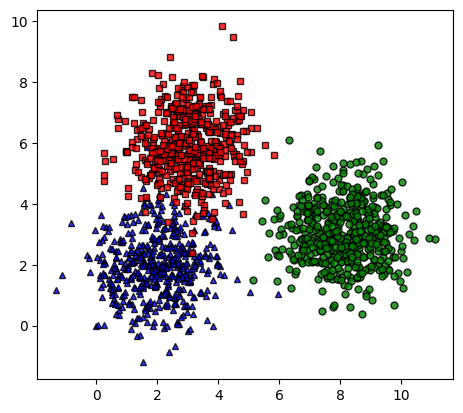

In [49]:
# Viết hàm K-means_display để hiển thị dữ liệu, sau đó hiển thị dữ liệu theo nhãn ban đầu
def kmeans_display(X, label):
    X0 = X[label == 0, :]
    X1 = X[label == 1, :]
    X2 = X[label == 2, :]

    kwargs = {'markersize': 5, 'alpha': 0.8, "markeredgecolor": 'k'}
    plt.plot(X0[:, 0], X0[:, 1], 'b^', **kwargs)
    plt.plot(X1[:, 0], X1[:, 1], 'go', **kwargs)
    plt.plot(X2[:, 0], X2[:, 1], 'rs', **kwargs)

    plt.axis([-3, 14, -2, 10])
    plt.axis('scaled')
    plt.plot()
    plt.show()

# Hiển thị dữ liệu theo nhãn ban đầu
kmeans_display(X, original_label)

In [50]:
def kmeans_init_centroids(X,k):
    # Chọn ngẫu nhiên k điểm từ X làm tâm cụm ban đầu
    return X[np.random.choice(X.shape[0], k)]

def kmeans_assign_labels(X, centroids):
    # Tính khoảng cách từ mỗi điểm đến các tâm cụm
    distances = cdist(X, centroids)
    # Gán nhãn cho mỗi điểm dữ liệu là chỉ số của tâm cụm gần nhất
    return np.argmin(distances, axis=1)

def kmeans_update_centroids(X, labels, k):
    centroids = np.zeros((k, X.shape[1]))
    for k in range(k):
        # Thu thập các điểm dữ liệu thuộc về cụm k
        Xk = X[labels == k, :]
        # Tính toán trung bình của các điểm dữ liệu trong cụm k
        centroids[k, :] = np.mean(Xk, axis=0)
    return centroids

def has_converged(centroids, new_centroids):
    return (set([tuple(c) for c in centroids]) == set([tuple(c) for c in new_centroids]))


### Phần chính của k-means Clustering

In [51]:
def kmeans(X, K):
    centroids = [kmeans_init_centroids(X, K)]
    labels = []
    it = 0
    while True:
        labels.append(kmeans_assign_labels(X, centroids[-1]))
        new_centroids = kmeans_update_centroids(X, labels[-1], K)
        if has_converged(centroids[-1], new_centroids):
            break
        centroids.append(new_centroids)
        it += 1
    return centroids, labels, it

Centers found by our algorithm:
 [[1.9834967  1.96588127]
 [3.02702878 5.95686115]
 [8.07476866 3.01494931]]


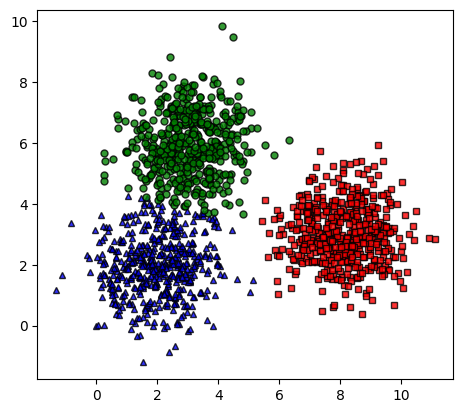

In [52]:
# Áp dụng thuật toán K-means cho dữ liệu đã tạo
centroids, labels, it = kmeans(X, K)
print('Centers found by our algorithm:\n', centroids[-1])
kmeans_display(X, labels[-1])

##### Từ kết quả này chúng ta thấy rằng thuật toán K-means đã làm việc khá thành công, các centroids tìm được của hai nhóm xanh, đỏ đã bị hoán đổi nhưng những điểm ban đầu thuộc cùng một cluster gần như vẫn cùng thuộc một cluster.

### Kết quả tìm được bằng thư viện Scikit-learn

Centers found by sklearn:
 [[8.07476866 3.01494931]
 [3.02521978 5.94885115]
 [1.98112961 1.95794411]]


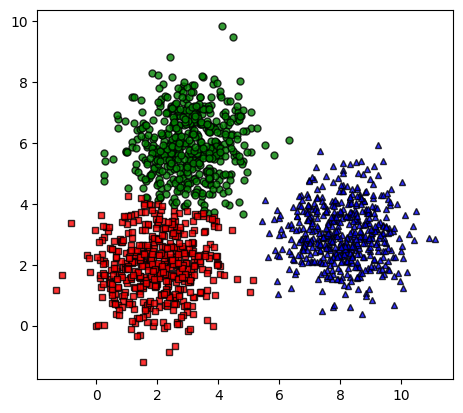

In [53]:
from sklearn.cluster import KMeans
# Sử dụng thư viện sklearn để áp dụng thuật toán K-means
model = KMeans(n_clusters=3, random_state=0).fit(X)
print('Centers found by sklearn:\n', model.cluster_centers_)
pred_label = model.predict(X)
kmeans_display(X, pred_label)

#### Voronoi

In [54]:
from scipy.spatial import Voronoi
from voronoi import voronoi_finite_polygons_2d

def kmeans_display_progress(X, centroids, labels, it, filename='ex.pdf', saving=False):
    label = labels
    X0 = X[label == 0, :]
    X1 = X[label == 1, :]
    X2 = X[label == 2, :]

    with PdfPages(filename) as pdf:
        kwargs = {'markersize': 5, 'alpha': 1, "markeredgecolor": 'k'}
        plt.plot(X0[:, 0], X0[:, 1], 'b^', **kwargs)
        plt.plot(X1[:, 0], X1[:, 1], 'go', **kwargs)
        plt.plot(X2[:, 0], X2[:, 1], 'rs', **kwargs)

        points = centroids[it]
        kwargs = {'markersize': 15, "markeredgecolor": 'k'}
        plt.plot(points[0, 0], points[0, 1], 'y^', **kwargs)
        plt.plot(points[1, 0], points[1, 1], 'yo', **kwargs)
        plt.plot(points[2, 0], points[2, 1], 'ys', **kwargs)

        colors = ['b', 'g', 'r']
        vor = Voronoi(points)
        regions, vertices = voronoi_finite_polygons_2d(vor, radius=1000)
        for i, region in enumerate(regions):
            polygon = vertices[region]
            plt.fill(*zip(*polygon), alpha=0.2, color=colors[i])

        plt.axis('scaled')
        plt.title('Iteration %d' % (it + 1))
        plt.xlim(-3, 14)
        plt.ylim(-2, 10)
        plt.grid()
        plt.plot()
        plt.tight_layout()
        plt.show()
        

#### Slow convergence

seed number:  0 number of iterations:  8


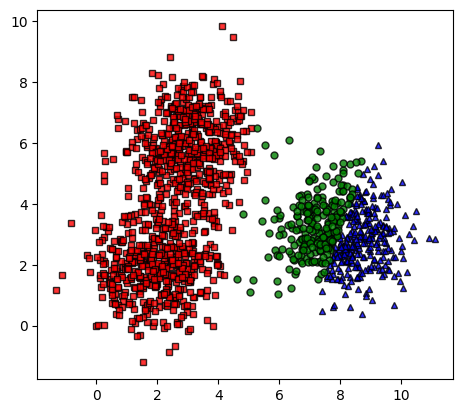

seed number:  9 number of iterations:  8


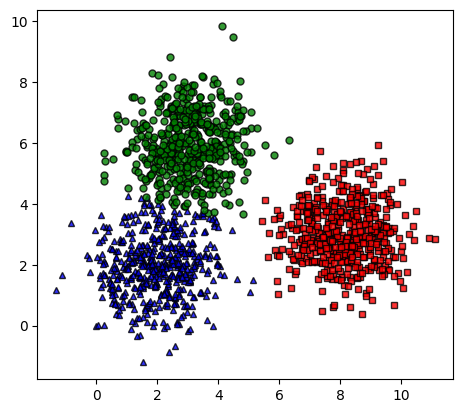

seed number:  18 number of iterations:  9


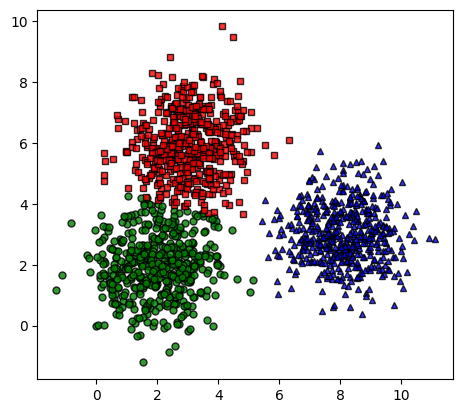

seed number:  27 number of iterations:  20


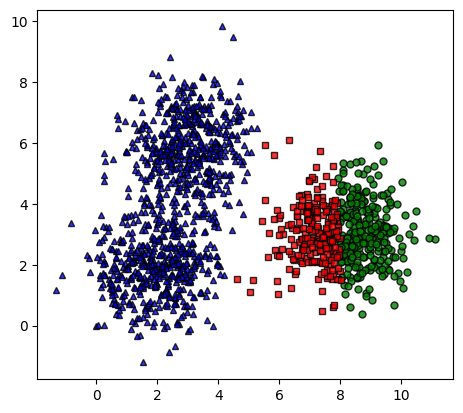

seed number:  36 number of iterations:  7


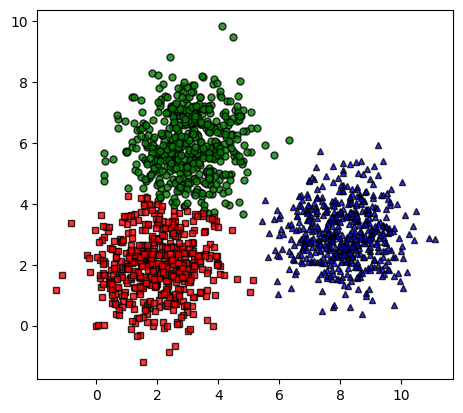

seed number:  45 number of iterations:  8


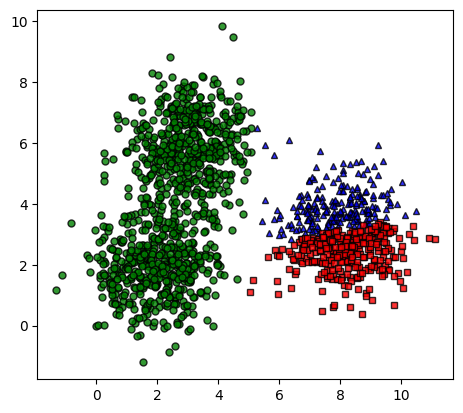

In [55]:
for i in range(6):
    np.random.seed(9*i)
    (centroids, labels, it) = kmeans(X, K)
    print('seed number: ', 9*i, 'number of iterations: ', len(labels))
    kmeans_display(X, labels[-1])

#### Nghiệm tìm được không như nhau

In [56]:
for i in range(60): 
    np.random.seed(i)
    (centroids, labels, it) = kmeans(X, K)
    print(centroids[-1])

[[8.78046073 2.78155578]
 [7.15025799 3.32261946]
 [2.48627752 3.975271  ]]
[[3.02702878 5.95686115]
 [1.9834967  1.96588127]
 [8.07476866 3.01494931]]
[[3.02702878 5.95686115]
 [8.07476866 3.01494931]
 [1.9834967  1.96588127]]
[[3.02702878 5.95686115]
 [8.07476866 3.01494931]
 [1.9834967  1.96588127]]
[[3.02702878 5.95686115]
 [8.07476866 3.01494931]
 [1.9834967  1.96588127]]
[[8.07476866 3.01494931]
 [1.9834967  1.96588127]
 [3.02702878 5.95686115]]
[[3.02702878 5.95686115]
 [8.07476866 3.01494931]
 [1.9834967  1.96588127]]
[[1.9834967  1.96588127]
 [3.02702878 5.95686115]
 [8.07476866 3.01494931]]
[[8.07476866 3.01494931]
 [3.02702878 5.95686115]
 [1.9834967  1.96588127]]
[[1.9834967  1.96588127]
 [3.02702878 5.95686115]
 [8.07476866 3.01494931]]
[[1.9834967  1.96588127]
 [3.02702878 5.95686115]
 [8.07476866 3.01494931]]
[[1.9834967  1.96588127]
 [3.02702878 5.95686115]
 [8.07476866 3.01494931]]
[[1.9834967  1.96588127]
 [3.02702878 5.95686115]
 [8.07476866 3.01494931]]
[[1.9834967 

10


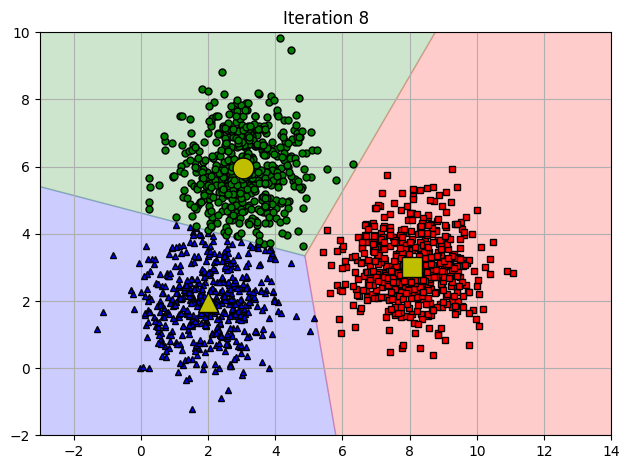

31


C:\Users\DELL\AppData\Local\Temp\ipykernel_12460\3100706091.py:36: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 3.8 and support will be removed two minor releases later.
  plt.show()


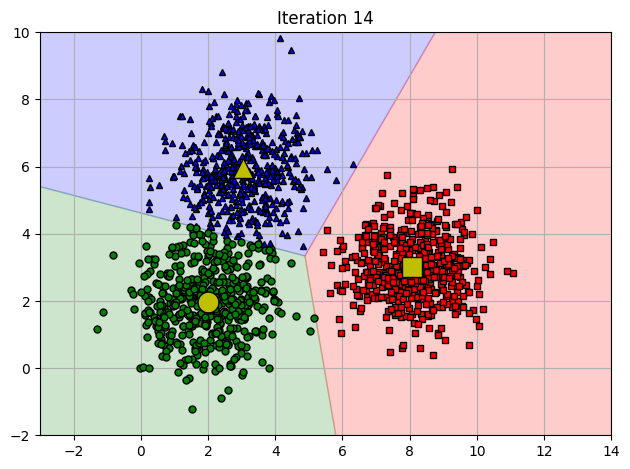

27


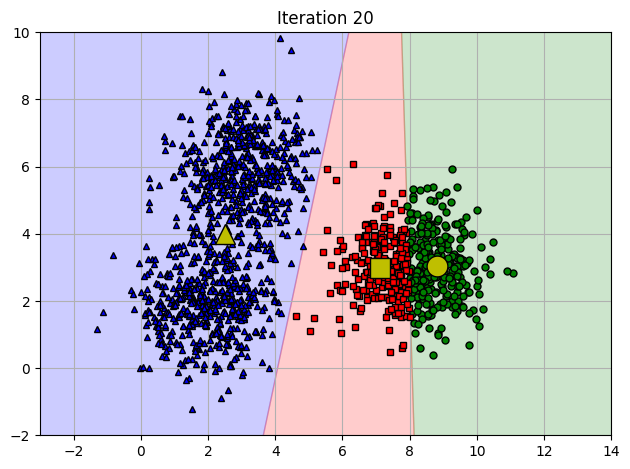

In [57]:
for i in [10, 31, 27]:
    np.random.seed(i)
    (centroids, labels, it) = kmeans(X, K)
    it = len(labels) - 1
    print(i)
    filename = 'dif_res' + str(i) + '.pdf'
    # Ensure labels[it] is 1D
    label = labels[it].ravel() if labels[it].ndim > 1 else labels[it]
    kmeans_display_progress(X, centroids, label, it, filename, saving=True)

#### Số lượng điểm chênh lệch

10


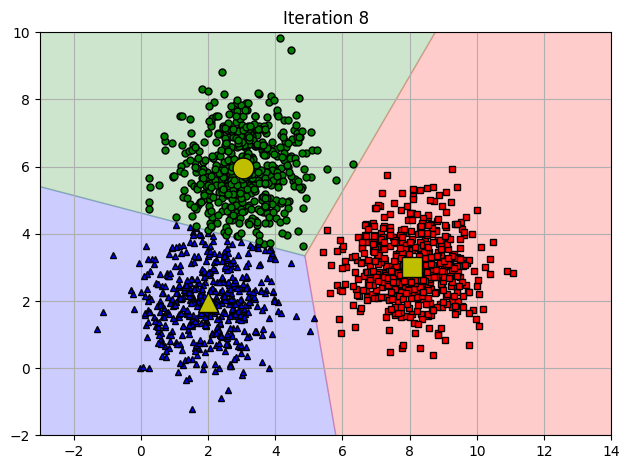

C:\Users\DELL\AppData\Local\Temp\ipykernel_12460\3100706091.py:36: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 3.8 and support will be removed two minor releases later.
  plt.show()


In [58]:
means = [[2, 2], [8, 3], [3, 6]]
cov = [[1, 0], [0, 1]]

# original_label = np.asarray([0] * N + [1] * N + [2] * N).T
N = 500
for i in [10]:
    np.random.seed(i)
    (centroids, labels, it) = kmeans(X, K)
    it = len(labels) - 1
    print(i)
    filename = 'skew' + str(i) + '.pdf'
    # Ensure labels[it] is 1D
    label = labels[it].ravel() if labels[it].ndim > 1 else labels[it]
    kmeans_display_progress(X, centroids, label, it, filename, saving=True)

#### Các cluster không có dạng tròn

10


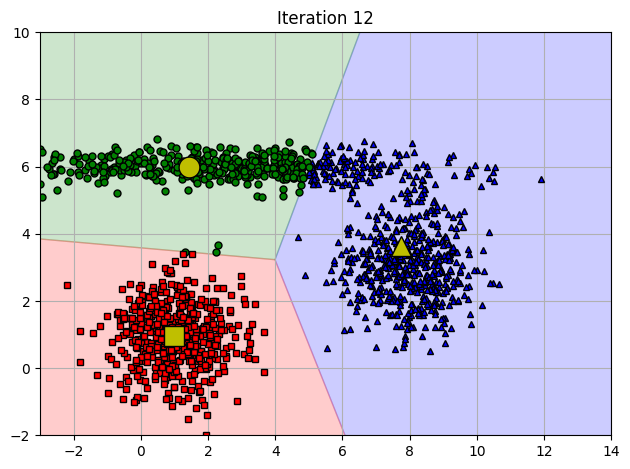

C:\Users\DELL\AppData\Local\Temp\ipykernel_12460\3100706091.py:36: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 3.8 and support will be removed two minor releases later.
  plt.show()


In [59]:
# Các cụm không có hình dạng cầu
means = [[1, 1], [8, 3], [3, 6]]
cov = [[1, 0], [0, 1]]
cov2 = [[10, 0], [0, .1]]
N = [500, 500, 500]

X0 = np.random.multivariate_normal(means[0], cov, N[0])
X1 = np.random.multivariate_normal(means[1], cov, N[1])
X2 = np.random.multivariate_normal(means[2], cov2, N[2])

X = np.concatenate((X0, X1, X2), axis=0)
K = 3
for i in [10]:
    np.random.seed(i)
    (centroids, labels, it) = kmeans(X, K)
    it = len(labels) - 1
    print(i)
    filename = 'not_round' + str(i) + '.pdf'
    # Ensure labels[it] is 1D
    label = labels[it].ravel() if labels[it].ndim > 1 else labels[it]
    kmeans_display_progress(X, centroids, label, it, filename, saving=True)